## kaggle 经典零售或商店销售数据集分析

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### 1. 数据处理: 使用 Pandas 读取数据，进行数据清洗

In [18]:
# 首先将数据全部存入 data 中
df = pd.read_csv("train.csv",sep=",")
print(df.head())
print("----------------------------------------------")
print("infomation:")
print(df.info())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
----------------------------------------------
infomation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [ ]:
# 数据清洗与检查
missing_values=df.isnull().sum()
print("--缺失值统计--")
print(missing_values)

--缺失值统计--
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [21]:
# 检查重复行
# 检查重复行数
duplicates = df.duplicated().sum()
print(f"\n重复行数: {duplicates}")

# 如果 duplicates > 0，则执行删除
if duplicates > 0:
    df = df.drop_duplicates()
    print("已删除重复行")


重复行数: 0


In [22]:
# 删除 index 部分，节省内存
# axis=1 表示操作的是列
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("\n--- 已删除无关列 'id' ---")


--- 已删除无关列 'id' ---


In [23]:
# 将 store_nbr 和 family 转换为 category 类型
df['store_nbr'] = df['store_nbr'].astype('category')
df['family'] = df['family'].astype('category')

print("\n--- 转换后的数据类型 ---")
print(df.dtypes)


--- 转换后的数据类型 ---
date             object
store_nbr      category
family         category
sales           float64
onpromotion       int64
dtype: object


In [ ]:
# 检查是否有负数销量
negative_sales = df[df['sales'] < 0]

if not negative_sales.empty:
    print(f"\n警告：发现 {len(negative_sales)} 条销量为负的数据！")
    # 建议：查看这些数据，或者将其修正为0/删除
    # df = df[df['sales'] >= 0]  # 删除负数行
else:
    print("\n数据逻辑检查通过：没有负数销量。")


数据逻辑检查通过：没有负数销量。


In [28]:
clean_df= df

### 2. 数据分析: 使用 Pandas 进行深度分析，回答至少三个业务问题

- 哪个商品大类的总销售额最高？

In [31]:
# 1. 按 'family' 分组，对 'sales' 列求和
# 2. 使用 sort_values(ascending=False) 从大到小排序
family_sales = clean_df.groupby('family',observed=True)['sales'].sum().sort_values(ascending=False)
print("--- 各大类总销量排名 (前5名) ---")
print(family_sales.head(5))


--- 各大类总销量排名 (前5名) ---
family
GROCERY I    3.434627e+08
BEVERAGES    2.169545e+08
PRODUCE      1.227047e+08
CLEANING     9.752129e+07
DAIRY        6.448771e+07
Name: sales, dtype: float64


In [ ]:
# 4. 获取具体的冠军类别和销量
top_family = family_sales.index[0]
top_sales = family_sales.iloc[0]

print(f"\n销售额最高的商品大类是: 【{top_family}】")
print(f"总销售额为: {top_sales:,.2f}")  # :,.2f 表示千分位分隔，保留两位小数


销售额最高的商品大类是: 【GROCERY I】
总销售额为: 343,462,734.89


- 促销效果分析：

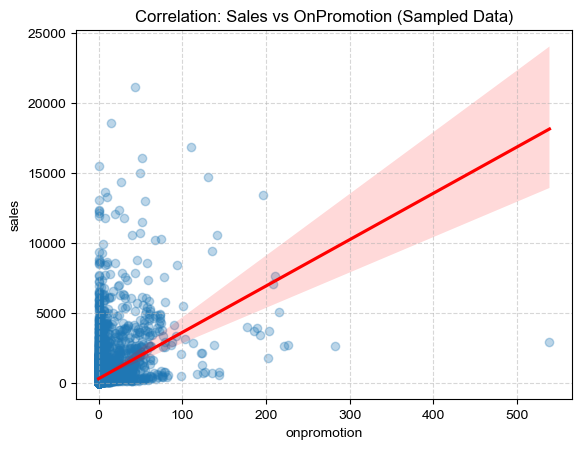

In [44]:
# 1. 由于数据量巨大，我们随机抽取 10,000 行数据进行绘图，足以体现趋势
sample_df = clean_df.sample(n=10000, random_state=42)

plt.Figure(figsize=(10,6))

# 2. 使用 seaborn 的 regplot (Regression Plot)
# x轴：onpromotion (促销数量)
# y轴：sales (销量)
# scatter_kws={'alpha': 0.3}: 设置点的透明度，方便观察重叠密度
# line_kws={'color': 'red'}: 设置回归线为红色，醒目
sns.regplot(x='onpromotion', y='sales', data=sample_df, 
            scatter_kws={'alpha': 0.3}, 
            line_kws={'color': 'red'})

plt.title('Correlation: Sales vs OnPromotion (Sampled Data)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

- 周一到周日，哪一天的平均销售额最高？

当前 date 列类型: datetime64[ns]

--- 星期销量排名 (从高到低) ---
day_name
Sunday       1.980523e+08
Saturday     1.861015e+08
Monday       1.488278e+08
Wednesday    1.423787e+08
Friday       1.390978e+08
Tuesday      1.379221e+08
Thursday     1.212646e+08
Name: sales, dtype: float64

销量最高的一天是: 【Sunday】


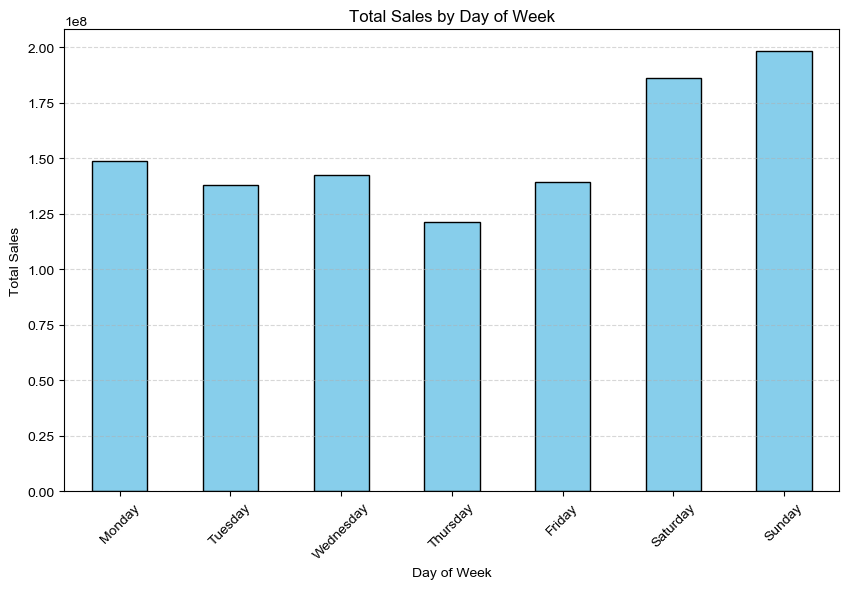

In [42]:
# --- 1. 强制转换 date 列为时间格式 ---
clean_df['date'] = pd.to_datetime(clean_df['date'])

# 检查一下，现在它应该是 datetime64 类型了
print("当前 date 列类型:", clean_df['date'].dtype)

# --- 2. 提取星期名称 ---
# 现在 .dt 访问器就可以使用了
clean_df['day_name'] = clean_df['date'].dt.day_name()

# --- 3. 分组统计 ---
# 按星期分组求和，并从大到小排序
weekly_sales = clean_df.groupby('day_name', observed=True)['sales'].sum().sort_values(ascending=False)

print("\n--- 星期销量排名 (从高到低) ---")
print(weekly_sales)

# 找出最高的一天
print(f"\n销量最高的一天是: 【{weekly_sales.index[0]}】")

# --- 4. 可视化 (按周一到周日顺序) ---
# 定义顺序
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# 按顺序重新排列数据
weekly_sales_sorted = weekly_sales.reindex(order)

plt.figure(figsize=(10, 6))
weekly_sales_sorted.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

- 2023年哪个季度的销售额同比增长最快？

In [45]:
target_year = 2016 
prev_year = 2015

# 数据准备：提取年份和季度
df_analysis = clean_df.copy()
df_analysis['year']= df_analysis['date'].dt.year
df_analysis['quarter'] = df_analysis['date'].dt.quarter

In [46]:
# 筛选这两年的数据
df_filtered = df_analysis[df_analysis['year'].isin([prev_year, target_year])]

In [49]:
if df_filtered.empty:
    print(f"错误：数据集中没有找到 {prev_year} 或 {target_year} 年的数据！")
    print(f"请根据第一步查出的年份修改 target_year 变量。")
else:
    # 按年份和季度分组求和 ---
    quarterly_sales = df_filtered.groupby(['year', 'quarter'])['sales'].sum().unstack(level=0)
    # 计算增长额 (Growth Amount) ---
    # 公式：今年 - 去年
    quarterly_sales['growth_amount'] = quarterly_sales[target_year] - quarterly_sales[prev_year]
    
    # 计算增长率 (Growth Rate %)
    quarterly_sales['growth_rate'] = (quarterly_sales['growth_amount'] / quarterly_sales[prev_year]) * 100

    # 排序并找出增长额最大的季度 ---
    result = quarterly_sales.sort_values('growth_amount', ascending=False)

    print(f"--- {target_year} vs {prev_year} 季度销售额同比增长情况 ---")
    print(result)

    # 获取第一名
    best_q = result.index[0]
    max_growth = result['growth_amount'].iloc[0]
    
    print(f"\n同比增长额最快(最高)的是: 【第 {best_q} 季度】")
    print(f"增长金额为: {max_growth:,.2f}")


--- 2016 vs 2015 季度销售额同比增长情况 ---
year             2015          2016  growth_amount  growth_rate
quarter                                                        
1        4.423793e+07  6.905699e+07   2.481907e+07    56.103601
2        5.430080e+07  7.295168e+07   1.865088e+07    34.347340
4        7.392720e+07  7.831332e+07   4.386115e+06     5.933019
3        6.841418e+07  6.833253e+07  -8.164091e+04    -0.119333

同比增长额最快(最高)的是: 【第 1 季度】
增长金额为: 24,819,069.15


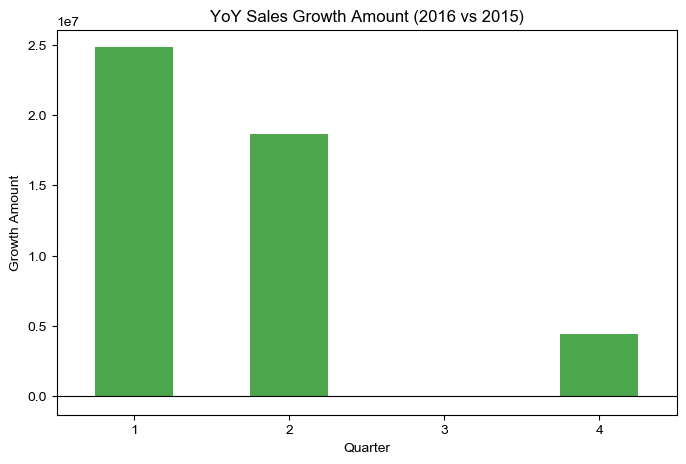

In [50]:
if not df_filtered.empty:
    plt.figure(figsize=(8, 5))
    
    # 画柱状图
    colors = ['green' if x > 0 else 'red' for x in result.sort_index()['growth_amount']]
    
    result.sort_index()['growth_amount'].plot(kind='bar', color=colors, alpha=0.7)
    
    plt.title(f'YoY Sales Growth Amount ({target_year} vs {prev_year})')
    plt.xlabel('Quarter')
    plt.ylabel('Growth Amount')
    plt.axhline(0, color='black', linewidth=0.8) # 画一条0轴线
    plt.xticks(rotation=0)
    
    plt.show()

  ### 4. 数据可视化: 使用 Matplotlib 或 Seaborn，为你的每一个分析结论制作一张清晰、有意义的可视化图表（如条形图、折线图）。

- **具体见上，已完成** 

### 5. 进一步分析：

1. "薪资日效应"分析 (The "Payday" Effect)
---
商业背景：在很多国家（特别是拉美地区），人们通常在 15号 和 月底 发工资。发了工资后的几天通常是消费高峰。
分析目标：统计每个月 1号到 31号的平均销量，看是否有明显的波峰。

In [51]:
# 获取‘日‘数据集
df_payday = clean_df.copy()
df_payday['day'] = df_payday['date'].dt.day



In [53]:
# 2. 按“日”分组计算平均销量
daily_pattern = df_payday.groupby('day')['sales'].mean()

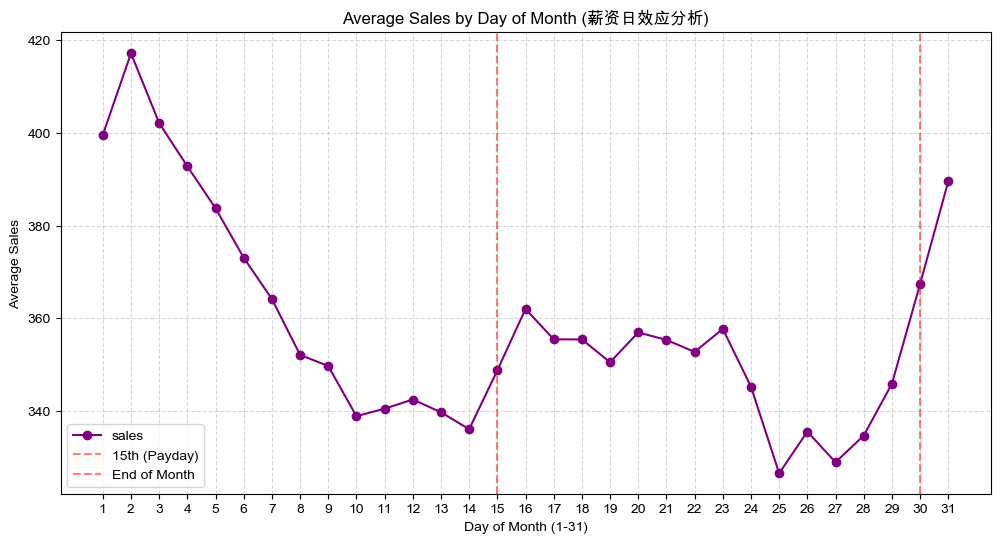

In [54]:
# 3. 绘图
plt.figure(figsize=(12, 6))
daily_pattern.plot(kind='line', marker='o', color='purple')

plt.title('Average Sales by Day of Month (薪资日效应分析)')
plt.xlabel('Day of Month (1-31)')
plt.ylabel('Average Sales')
plt.xticks(range(1, 32)) # 显示1到31的所有刻度
plt.grid(True, linestyle='--', alpha=0.5)

# 标记出 15号 和 30号
plt.axvline(x=15, color='red', linestyle='--', alpha=0.5, label='15th (Payday)')
plt.axvline(x=30, color='red', linestyle='--', alpha=0.5, label='End of Month')
plt.legend()

plt.show()

可以看出，在每个月的月初、月末和月中都有一部分的销售量提升，月末尤为明显，工资日效应非常的标准

2. 移动平均趋势分析 (Rolling Average Trend)
--- 
商业背景：日销量波动很大（噪点多），直接看图会像心电图一样乱。我们需要“抚平”波动，看长期的上升或下降趋势。
分析目标：计算 30天移动平均线（30-Day Moving Average）。



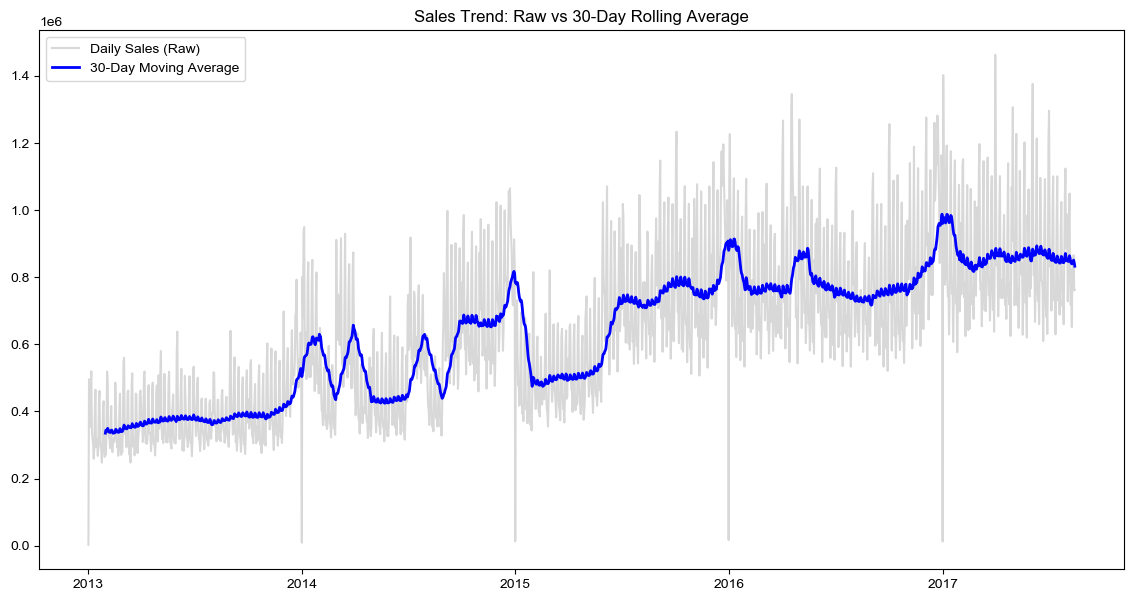

In [55]:
# 1. 按日期汇总总销量
total_daily_sales = clean_df.groupby('date')['sales'].sum()

# 2. 计算 30天滚动平均
# window=30: 窗口大小为30天
rolling_sales = total_daily_sales.rolling(window=30).mean()

# 3. 绘图对比
plt.figure(figsize=(14, 7))
# 原始数据（透明度调低，作为背景）
plt.plot(total_daily_sales, alpha=0.3, color='gray', label='Daily Sales (Raw)')
# 移动平均线（深色，加粗）
plt.plot(rolling_sales, color='blue', linewidth=2, label='30-Day Moving Average')

plt.title('Sales Trend: Raw vs 30-Day Rolling Average')
plt.legend()
plt.show()

3. 商店业绩箱线图 (Store Performance Distribution)
---
商业背景：虽然我们知道哪个店卖得最多，但我们不知道它们是否稳定。有的店可能平时很差，偶尔一天极高；有的店虽然不是第一，但非常稳定。
分析目标：使用箱线图（Boxplot）观察不同商店的销量分布情况。

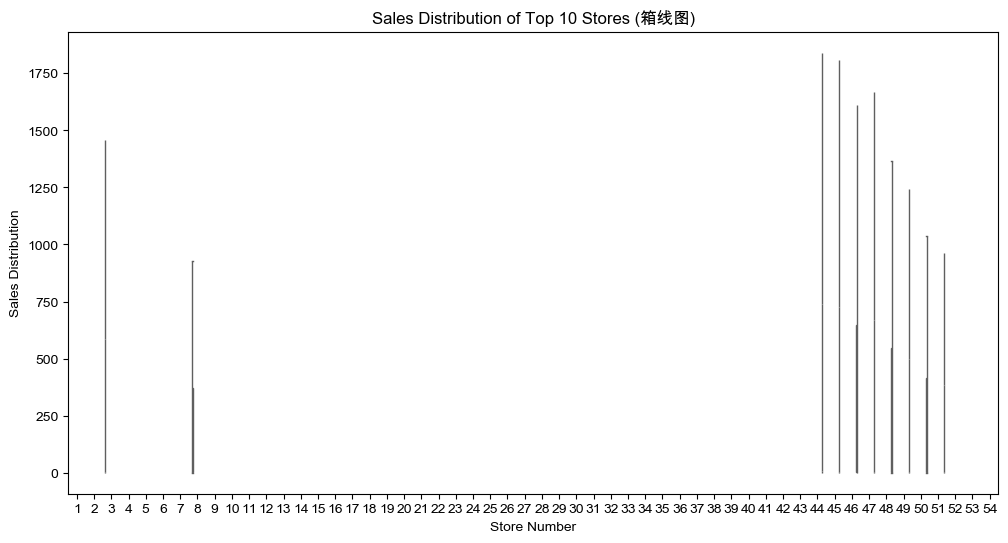

In [57]:

# 1. 重新获取前10名商店的索引 (同时加上 observed=True 消除 Pandas 警告)
top_10_stores = clean_df.groupby('store_nbr', observed=True)['sales'].sum().sort_values(ascending=False).head(10).index

# 2. 筛选数据
df_top_stores = clean_df[clean_df['store_nbr'].isin(top_10_stores)]

# 3. 绘图 (修正版)
plt.figure(figsize=(12, 6))

# 关键修改：
# 1. 加上 hue='store_nbr'
# 2. 加上 legend=False (不需要图例，因为x轴已经写了)
sns.boxplot(x='store_nbr', 
            y='sales', 
            data=df_top_stores, 
            hue='store_nbr',     # 新增：指定颜色依据
            legend=False,        # 新增：隐藏图例
            showfliers=False, 
            palette='Set3')

plt.title('Sales Distribution of Top 10 Stores (箱线图)')
plt.xlabel('Store Number')
plt.ylabel('Sales Distribution')
plt.show()

4. 季节性热力图 (Seasonality Heatmap)
---
商业背景：某些月份是淡季，某些是旺季（如12月圣诞节）。我们需要一张图一眼看清几年的所有月份表现。
分析目标：横轴为月份，纵轴为年份，颜色深浅代表销量。

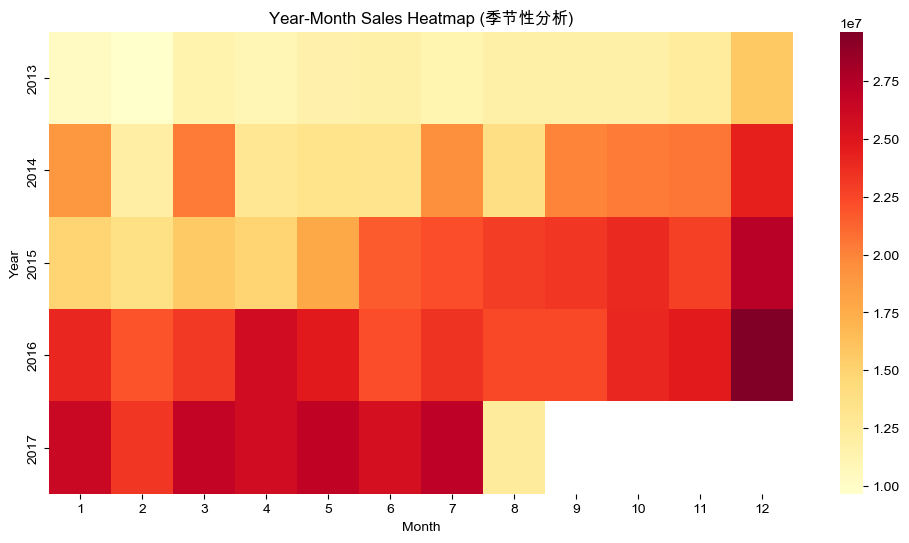

In [58]:
# 1. 准备数据：按年、月分组求和
# 提取月份
clean_df['month'] = clean_df['date'].dt.month
clean_df['year'] = clean_df['date'].dt.year

# 创建透视表：行=年，列=月，值=销量
pivot_table = clean_df.pivot_table(values='sales', index='year', columns='month', aggfunc='sum')

# 2. 绘制热力图
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, fmt='.0f') 
# cmap='YlOrRd': 黄色到红色，越红卖得越好

plt.title('Year-Month Sales Heatmap (季节性分析)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()
